In [1]:
import numpy as np # had to downgrade NumPy to resolve compatiblity issue
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 99)

### Distribution of SalePrice
- a unimodal, strongly right-skewed distribution with a dense mass around roughly 120k–200k and a long, sparse tail out past 400k–700k. The high tail pulls the mean above the median, and a few very expensive homes act as outliers.
- Use a log transform (log1p(SalePrice)) for modeling/EDA to stabilize variance and make relationships more linear.

(array([  3.,  14.,  24.,  77., 105., 196., 312., 327., 217., 193., 200.,
        116., 109.,  87.,  73.,  53.,  54.,  37.,  24.,  32.,  25.,  14.,
          8.,  18.,  11.,   6.,  11.,   3.,   5.,   4.,   4.,   0.,   2.,
          0.,   2.,   0.,   1.,   0.,   2.,   1.,   3.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 35000.,  49400.,  63800.,  78200.,  92600., 107000., 121400.,
        135800., 150200., 164600., 179000., 193400., 207800., 222200.,
        236600., 251000., 265400., 279800., 294200., 308600., 323000.,
        337400., 351800., 366200., 380600., 395000., 409400., 423800.,
        438200., 452600., 467000., 481400., 495800., 510200., 524600.,
        539000., 553400., 567800., 582200., 596600., 611000., 625400.,
        639800., 654200., 668600., 683000., 697400., 711800., 726200.,
        740600., 755000.]),
 <BarContainer object of 50 artists>)

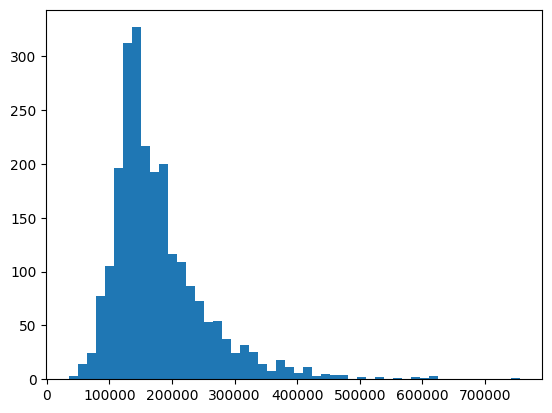

In [39]:
fig, ax = plt.subplots()
ax.hist(df['SalePrice'], bins=50)

(array([  1.,   1.,   0.,   0.,   1.,   0.,   2.,   3.,   4.,  11.,   5.,
          4.,   7.,  28.,  28.,  30.,  30.,  59.,  76.,  98., 142., 197.,
        189., 165., 173., 127., 146., 158.,  99., 103.,  86.,  70.,  63.,
         62.,  43.,  34.,  34.,  19.,  23.,  14.,  13.,   8.,   6.,   2.,
          3.,   1.,   5.,   0.,   0.,   1.]),
 array([10.46313191, 10.52455876, 10.58598561, 10.64741246, 10.70883931,
        10.77026616, 10.831693  , 10.89311985, 10.9545467 , 11.01597355,
        11.0774004 , 11.13882725, 11.2002541 , 11.26168095, 11.3231078 ,
        11.38453464, 11.44596149, 11.50738834, 11.56881519, 11.63024204,
        11.69166889, 11.75309574, 11.81452259, 11.87594943, 11.93737628,
        11.99880313, 12.06022998, 12.12165683, 12.18308368, 12.24451053,
        12.30593738, 12.36736423, 12.42879107, 12.49021792, 12.55164477,
        12.61307162, 12.67449847, 12.73592532, 12.79735217, 12.85877902,
        12.92020586, 12.98163271, 13.04305956, 13.10448641, 13.16591326,
 

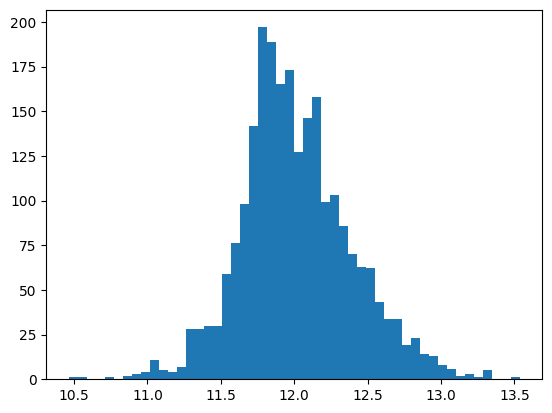

In [40]:
fig, ax = plt.subplots()
ax.hist(np.log1p(df['SalePrice']), bins=50)

### Assess if YrSold has a meaningful impact on the SalePrice

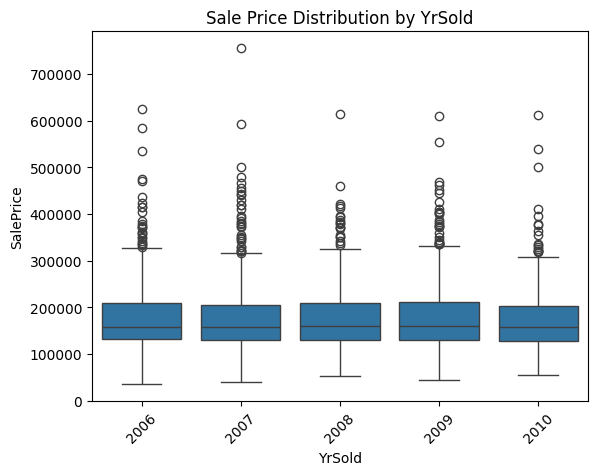

In [26]:
# the median Saleprice does not seem to vary a lot across all years
sns.boxplot(x='YrSold', y='SalePrice', data=df)
plt.xticks(rotation=45)
plt.title("Sale Price Distribution by YrSold")
plt.show()

#### Use ANOVA to compare mean prices across all years
- There is no statistically significant difference in the mean prices between the years.

In [27]:
from scipy.stats import f_oneway

# Group the sales prices by year
prices_by_year = [df[df['YrSold'] == year]['SalePrice'].values for year in df['YrSold'].unique()]

# Perform the ANOVA test
f_statistic, p_value = f_oneway(*prices_by_year)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 0.2802432239058666
P-value: 0.8908972532575593


### Analysis around Neighborhood, GrLivArea and OverallQual features
- IQR (Interquartile Range) is the spread of the middle 50% of values
- IQR = Q3 − Q1, where Q1 is the 25th percentile and Q3 is the 75th. It’s robust to outliers, so it summarizes typical variability better than the full range.
- How to read it:
*Higher dot → pricier neighborhood (on the log scale).

*Shorter IQR bar → more uniform prices; homes are similar in value.

*Longer IQR bar → mixed market; wide variety of home values (possible sub-markets or renovations/new builds vs older stock).

*Overlapping IQRs between neighborhoods → their price distributions aren’t clearly separated; rank differences may be modest in practice.

*High median + short IQR → “consistently premium.”

*High median + long IQR → premium on average, but lots of variation.

*Low median + short IQR → consistently affordable.


#### Rank neighborhoods by median log-price + show dispersion (IQR)

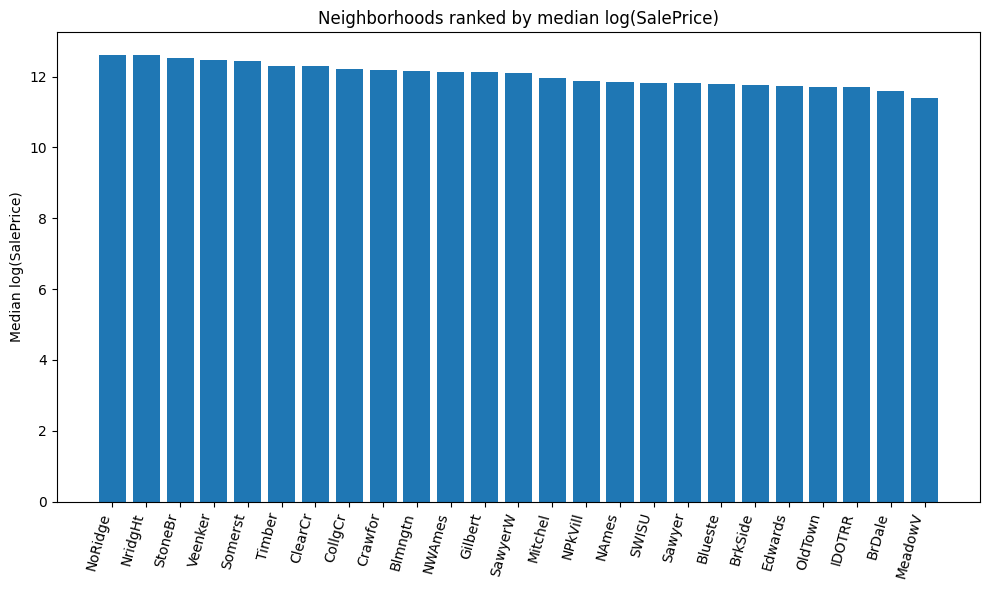

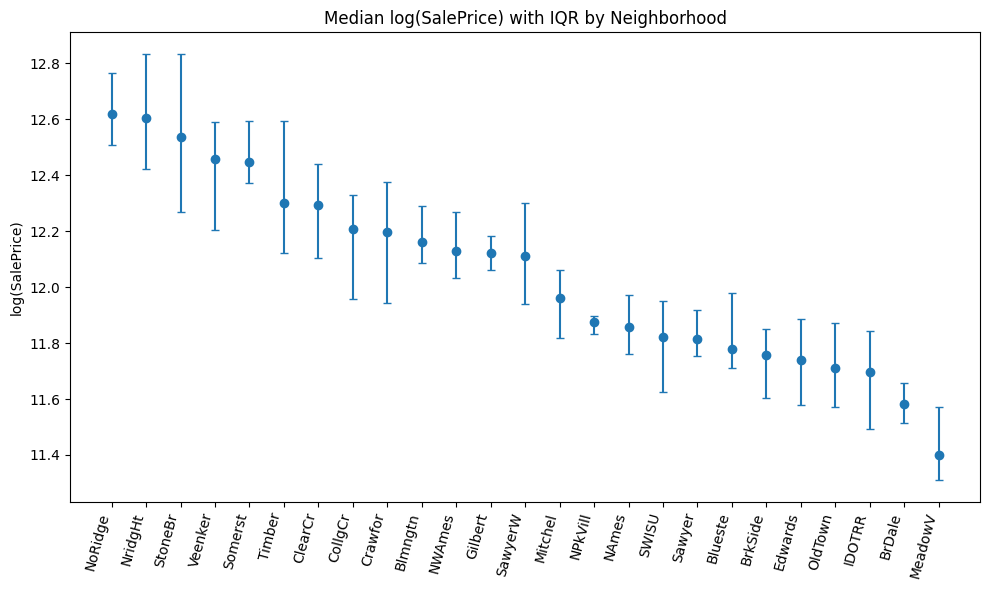

In [79]:
# base columns you’ll need; adjust names if yours differ
needed = {'SalePrice','Neighborhood','OverallQual','GrLivArea'}
missing = needed - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# 1. target on log scale (nicer distribution)
#df = df.copy()
#df = df[df['SalePrice'].notna()]
df['log_price'] = np.log1p(df['SalePrice'])


# summary per neighborhood
g = df.groupby('Neighborhood')['log_price']
summary = pd.DataFrame({
    'n': g.size(),
    'median': g.median(),
    'q1': g.quantile(0.25),
    'q3': g.quantile(0.75)
}).sort_values('median', ascending=False)

# optional: filter away tiny groups
summary = summary[summary['n'] >= 10]  # tweak threshold if needed

# plotting order
order = summary.index.tolist()

# ---- Chart A: median log-price, ranked ----
plt.figure(figsize=(10, 6))
plt.bar(range(len(order)), summary.loc[order, 'median'])
plt.xticks(range(len(order)), order, rotation=75, ha='right')
plt.ylabel('Median log(SalePrice)')
plt.title('Neighborhoods ranked by median log(SalePrice)')
plt.tight_layout()
plt.show()

# ---- Chart B: median with IQR error bars ----
med = summary.loc[order, 'median'].values
q1  = summary.loc[order, 'q1'].values
q3  = summary.loc[order, 'q3'].values
yerr = np.vstack([med - q1, q3 - med])  # asymmetric errors: [lower, upper]

plt.figure(figsize=(10, 6))
plt.errorbar(x=np.arange(len(order)), y=med, yerr=yerr, fmt='o', capsize=3)
plt.xticks(range(len(order)), order, rotation=75, ha='right')
plt.ylabel('log(SalePrice)')
plt.title('Median log(SalePrice) with IQR by Neighborhood')
plt.tight_layout()
plt.show()

#### Compare area distributions (boxplot of GrLivArea)

In [88]:
len(summary)

25

In [89]:
# pick top neighborhoods
# 28 neighborhoods in total
top_k = 25  # change if you want less
top_neigh = order[:top_k] #ordered by the median of log SalePrice
df_top = df.loc[df['Neighborhood'].isin(top_neigh)]

#### Observations:
- For Neighborhoods that the the mean marker sits well above the median, the neighborhood’s size distribution is right-skewed (a few very large homes)
- Houses in NoRidge tend to have larger above the ground living area in square feet compared to other neighborhoods which suggests the higher prices at at least partyly due to its size.
- Overlap of IQRs across neighborhoods such as Veenker, Somerst, Timber and Clearcr suggests size alone won't separate them, location or other factors probably impact the prices as well.

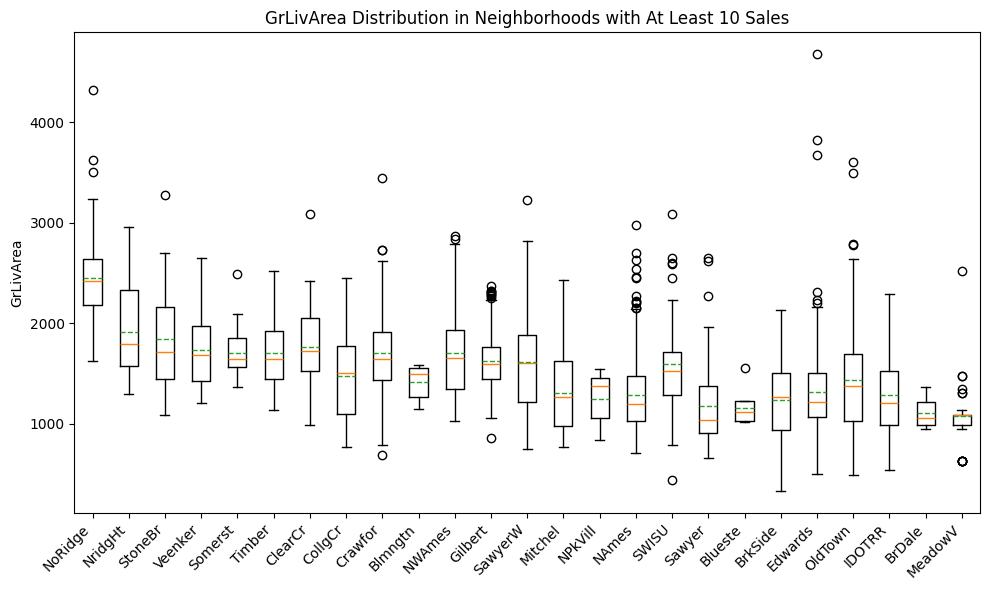

In [90]:
# Compare area distributions (boxplot of GrLivArea)
# optional: log-scale area if heavily skewed
#df_top['log_area'] = np.log1p(df_top['GrLivArea'])

# ensure consistent order
groups = [df_top.loc[df_top['Neighborhood']==nb, 'GrLivArea'].dropna().values for nb in top_neigh]

plt.figure(figsize=(10, 6))
plt.boxplot(groups, tick_labels=top_neigh, showmeans=True, meanline=True) # mean will be green triangle if no meanline parameter
plt.xticks(rotation=45, ha='right')
plt.ylabel('GrLivArea')
plt.title('GrLivArea Distribution in Neighborhoods with At Least 10 Sales')
plt.tight_layout()
plt.show()

#### Compare quality composition (stacked bar of OverallQual distribution)

In [93]:
df.groupby('OverallQual')['SalePrice'].describe()[['count','mean','50%']].rename(columns={'50%':'median'})

,count,mean,median
OverallQual,,,
1,2.0,50150.000000,50150.0
2,9.0,58667.111111,60000.0
3,29.0,87770.689655,82375.0
4,178.0,110294.629213,108000.0
5,717.0,136190.683403,134900.0
6,629.0,162123.939587,158500.0
7,466.0,205736.909871,200000.0
8,255.0,273359.949020,270000.0
9,71.0,366346.873239,360000.0


In [62]:
#df.OverallQual.nunique()
df.OverallQual.value_counts()

OverallQual
5     717
6     629
7     466
8     255
4     178
9      71
3      29
10     18
2       9
1       2
Name: count, dtype: int64

#### Observations:
- Neighborhoods from left to right in the plot are ranked in descending order by the median of log SalePrice in that Neighborhoods. Here we only include neighborhoods with at least 10 sales to ensure medians and IQRs are based on suffucient data. Neighborhoods with fewer sales were excluded due to higher sampling variability.

- Each bar represents a neighborhood, and the colored segments stack to 100% of homes there, split by OverallQual (1–10). 1 being "Very Poor" to 10 being "Very Excellent".

- We notice that top-priced neighborhoods have bigger chunk of higher rated houses which indicates that part of its price premium is likely composition (better stock), not pure location.

- When comparing across neighborhoods, Somerst seems to have more high-quality shares compared to Veenker but Veenker's median log SalePrice is slightly higher than Somerst's. Does that suggest a location premium beyond quality? I think so. Similar situation is also seen when comparing ClearCr, or CollgCr, or Crawfor to Blmngtn.

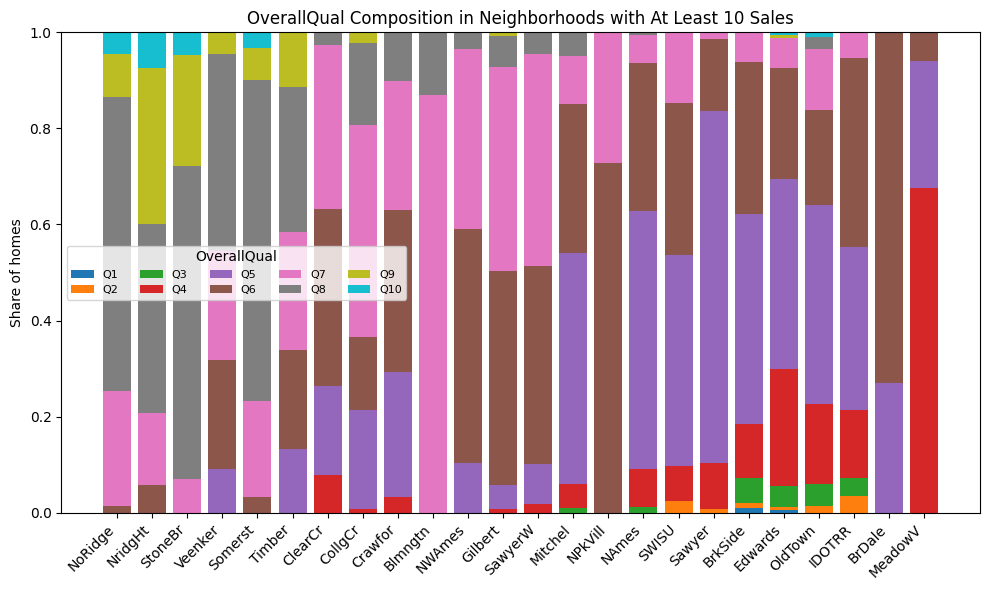

In [80]:
# make OverallQual numeric and sane
qual = df_top[['Neighborhood','OverallQual']].dropna()#.copy()
# clamp to 1..10 just in case, then cast int
#qual['OverallQual'] = qual['OverallQual'].clip(lower=1, upper=10).astype(int)

# normalized value counts (row = neighborhood; col = quality level)
qual_dist = (
    qual.groupby('Neighborhood')['OverallQual']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
        .reindex(index=top_neigh, columns=sorted(qual['OverallQual'].unique()))
)

# Stacked bar (each neighborhood sums to 1.0)
plt.figure(figsize=(10, 6))
bottom = np.zeros(len(qual_dist))
x = np.arange(len(qual_dist))

for q in qual_dist.columns:  # qualities ascending
    vals = qual_dist[q].values
    plt.bar(x, vals, bottom=bottom, label=f'Q{q}')
    bottom += vals

plt.xticks(x, qual_dist.index, rotation=45, ha='right')
plt.ylabel('Share of homes')
plt.title('OverallQual Composition in Neighborhoods with At Least 10 Sales')
plt.legend(title='OverallQual', ncol=5, fontsize=8)
plt.tight_layout()
plt.show()

### Check seasonality
- Across all these years, second quarter always had the most sales 

In [30]:
monthly_counts = df['MoSold'].value_counts().sort_index()
print(monthly_counts)

quarterly_counts = (
    housing
    .groupby(['YrSold', 'QrtSold'])
    .size()
    .reset_index(name='SalesCount')
    .sort_values(['YrSold', 'QrtSold'])
)

quarterly_counts

MoSold
1      92
2     110
3     192
4     228
5     341
6     426
7     379
8     178
9     116
10    132
11    105
12     75
Name: count, dtype: int64


,YrSold,QrtSold,SalesCount
0,2006,Q1,71
1,2006,Q2,185
2,2006,Q3,148
3,2006,Q4,69
4,2007,Q1,94
5,2007,Q2,208
6,2007,Q3,176
7,2007,Q4,80
8,2008,Q1,70
9,2008,Q2,214


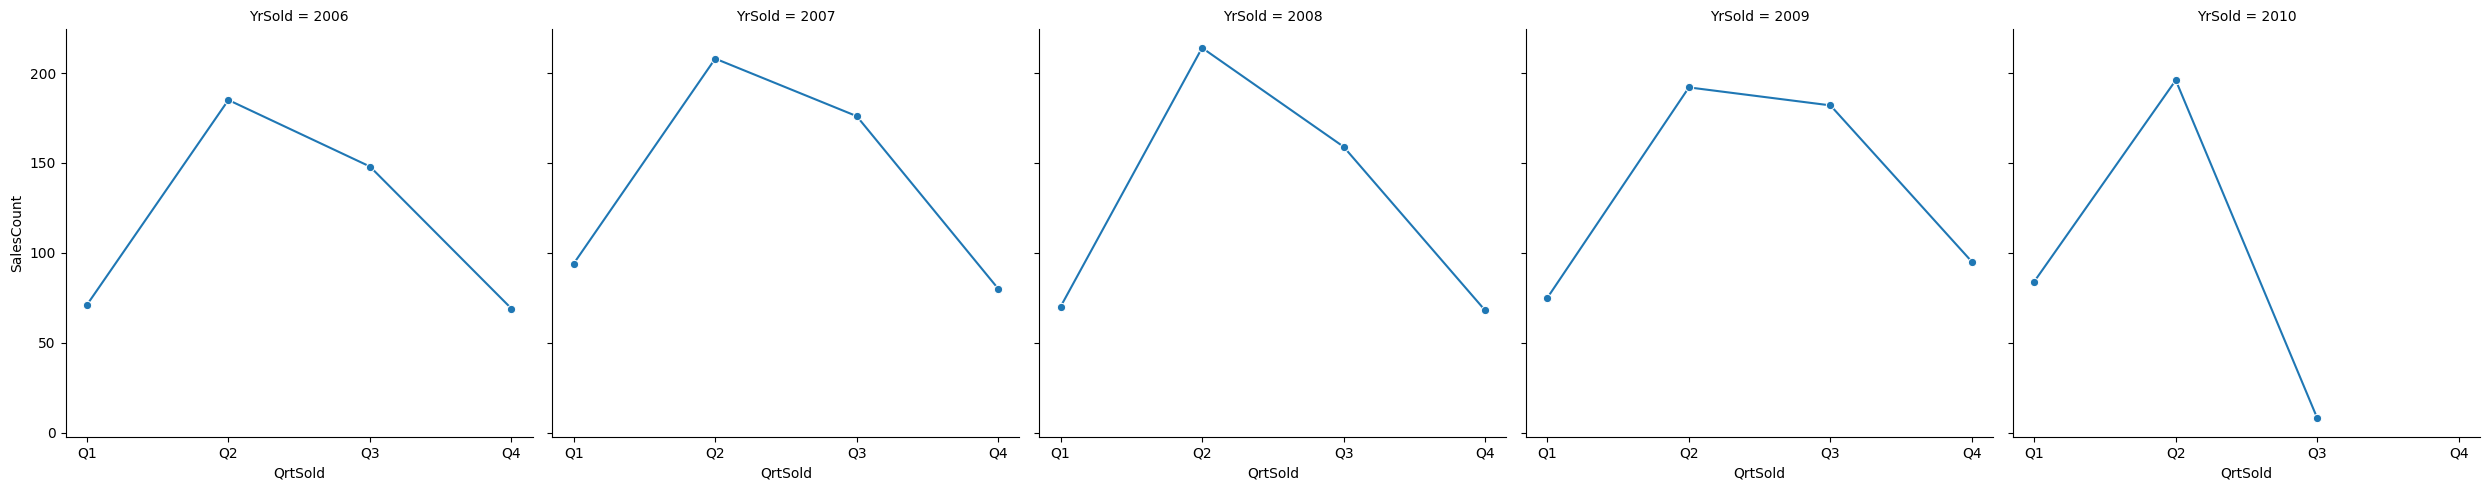

In [32]:
sns.relplot(data=quarterly_counts, x='QrtSold', y='SalesCount', col='YrSold', kind='line', marker='o', col_wrap=5)

### Use scatterplot to view interactions between variables

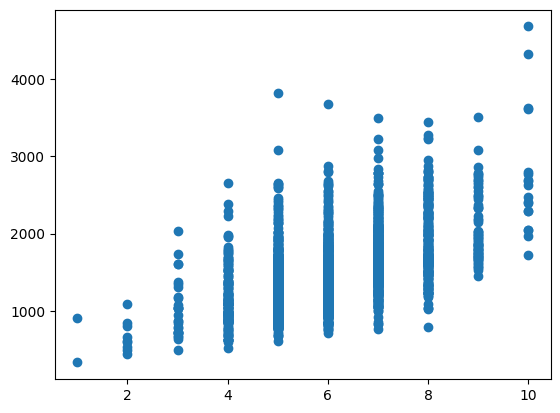

In [38]:
plt.scatter(df.OverallQual, df.GrLivArea)

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

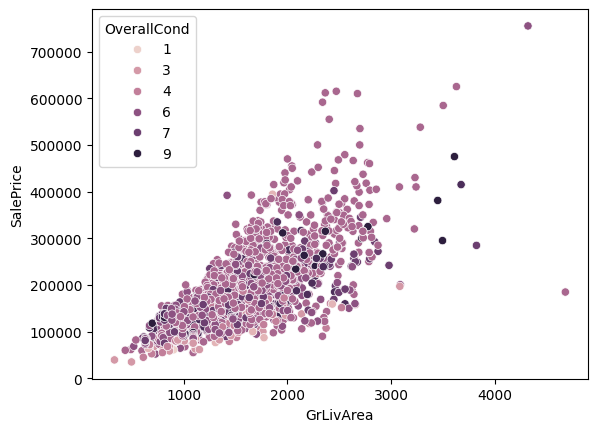

In [94]:
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice', hue='OverallCond')

### Other visualization [ideas](https://nycdatascience.com/blog/student-works/machine-learning-for-predicting-housing-prices-in-ames-iowa/)